# Notebook on self-knowledge in commentaries on book 3

This notebook contains the quantitative analyses of the doctrinal network for the chapter on book 3.

## Database note

I am using a different schema that enables more detailed analysis of doctrines. 
Using the `(:Instance)` node as a blank node between a `(:Question)` and a `(:Doctrine)` no doctrine is embedded in a fixed structure. It is in stead possible to determine the specific use of a doctrine by any given commentator, and it does not need to be reflected by any others.

## Annotation and registration note

It should be noted that the doctrines recorded in the graph database will nto match exactly the doctrines that are described in the dissertation. The dissertation presents a different layer of presentation, and there will therefore be doctrines that have not been considered sufficiently central to warrant space in the dissertation proper. When we reach a certain level of detail not all doctrines are registered in the appendix of the dissertation (normally doctrines with just one instance) unless they are of special interest in the discussion. The database is thus more detailed and contains more doctrines than are registered in the dissertation.

# Analysis

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from os import path

from utilities import save_table, print_figure_inclusion, build_matrix

from py2neo import Graph
graph = Graph('https://hobby-ijiahihliahcgbkepnpggmbl.dbs.graphenedb.com:24780/db/data/',
              user='remote',
              password="b.WKJhDFo38DGT.XBFHkuTL7R6BEEgw")

sns.set_context("paper", font_scale=1.5)

#pd.set_option('display.max_colwidth', -1)

In [2]:
author_names = graph.run('MATCH (n:Author) where not n.name = "Aristotle" RETURN n.name ORDER BY n.name asc').to_data_frame()['n.name']

In [3]:
author_names

0              Anonymus Assisi
1               Anonymus Bazan
2            Anonymus Digby 55
3    Anonymus Vat. Lat. 2170 2
4            Henric de la Wyle
5                John Dinsdale
6               John of Jandun
7              Radulphus Brito
8             Siger of Brabant
9           Simon of Faversham
Name: n.name, dtype: object

## Quantities

In [4]:
# Number of doctrines
q = ("MATCH (d:Doctrine) RETURN count(d)")
total_doctrines = graph.run(q).evaluate()

# Number of instances
q = ("MATCH (i:Instance) RETURN count(i)")
total_instances = graph.run(q).evaluate()

# Number of conclusion doctrines
q = ("MATCH (i:Instance {type:'Conclusion'})-[:OF]->(d:Doctrine) "
     "RETURN count(distinct d)")
conclusion_doctrines = graph.run(q).evaluate()

# Number of conclusion instances
q = ("MATCH (i:Instance {type:'Conclusion'}) RETURN count(i)")
conclusion_instances =  graph.run(q).evaluate()

# Number of positive doctrines (doctrines with instances that are not in a rationes context)
q = ("MATCH (i:Instance)--(d:Doctrine) "
     "WHERE not exists(i.type) or i.type = 'Conclusion' "
     "RETURN count(distinct d)")
positive_doctrines =  graph.run(q).evaluate()

# Number of instances of positive doctrines
q = ("MATCH (i:Instance)--(d:Doctrine) "
     "WHERE not exists(i.type) or i.type = 'Conclusion' "
     "RETURN count(distinct i)")
positive_instances =  graph.run(q).evaluate()

# Number of attacks doctrines
q = ("MATCH (i:Instance {type:'Attack'})-[:OF]->(d:Doctrine) "
     "RETURN count(distinct d)")
attack_doctrines = graph.run(q).evaluate()

# Number of attack instances
q = ("MATCH (i:Instance {type:'Attack'}) "
     "RETURN count(i)")
attack_instances = graph.run(q).evaluate()

# Number of refutation doctrines
q = ("MATCH (i:Instance {type:'Refutation'})-[:OF]->(d:Doctrine) "
     "RETURN count(distinct d)")
refutation_doctrines = graph.run(q).evaluate()

# Number of refutation instances
q = ("MATCH (i:Instance {type:'Refutation'}) "
     "RETURN count(i)")
refutation_instances = graph.run(q).evaluate()

In [5]:
quantities = {
    'All': [total_doctrines, total_instances, round(total_doctrines / total_instances, 2)],
    'Determination': [positive_doctrines, positive_instances, round(positive_doctrines / positive_instances, 2)],
    # 'Conclusions': [conclusion_doctrines, conclusion_instances, round(conclusion_doctrines / conclusion_instances, 2)],
    'Attack': [attack_doctrines, attack_instances, round(attack_doctrines / attack_instances, 2)],
    'Refutation': [refutation_doctrines, refutation_instances, round(refutation_doctrines / refutation_instances, 2)]
}
data = pd.DataFrame(quantities)
data.index = ['Doctrines', 'Instances', 'Proportion']
data.index.name = 'Context'
sum_table = data[['Determination', 'Attack', 'Refutation', 'All']].T
sum_table[['Doctrines', 'Instances']] = sum_table[['Doctrines', 'Instances']].astype(int)
sum_table

Context,Doctrines,Instances,Proportion
Determination,35,88,0.40
Attack,28,61,0.46
Refutation,24,62,0.39
All,75,213,0.35


In [6]:
save_table(
    filename='../thesis/data/tables/doctrines-instances.tex',
    table=sum_table.to_latex(),
    caption='Number of doctrines and instances in four different context classes.',
    label='tab:science:quantities:doctrines-instances'
)

Printed the following table to ../thesis/data/tables/doctrines-instances.tex:
\\begin{table}
\centering
\begin{tabular}{lrrr}
\toprule
Context &  Doctrines &  Instances &  Proportion \\
\midrule
Determination &         35 &         88 &        0.40 \\
Attack        &         28 &         61 &        0.46 \\
Refutation    &         24 &         62 &        0.39 \\
All           &         75 &        213 &        0.35 \\
\bottomrule
\end{tabular}
\caption{Number of doctrines and instances in four different context classes.}
\label{tab:science:quantities:doctrines-instances}
\end{table}


Notice that the "All" column is not the sum of the other columns, as one doctrine can easily be used for both attacking, refutating and as a general positive instance. The instance number is however identical with the sum of the columns "Positive", "Attacks", and "Refutations".

### Doctrines per commentator

In [7]:
# Doctrine count distributions
distributions = graph.run("match (a:Author)--(:Text)--(:Question)--(:Instance)--(d:Doctrine) "
                          "return count(distinct d) as cnt, a.name order by cnt desc").to_data_frame()
distributions

,a.name,cnt
0,John of Jandun,33
1,Radulphus Brito,29
2,Anonymus Bazan,20
3,John Dinsdale,19
4,Henric de la Wyle,16
5,Anonymus Assisi,15
6,Simon of Faversham,14
7,Anonymus Vat. Lat. 2170 2,12
8,Anonymus Digby 55,11
9,Siger of Brabant,8


In [8]:
distributions.describe()

,cnt
count,10.00000
mean,17.70000
std,7.91693
min,8.00000
25%,12.50000
50%,15.50000
75%,19.75000
max,33.00000


### Instances of doctrines

In [9]:
# Doctrine count instance distributions
q = ("MATCH (i:Instance)-[:OF|SUPPORTS|ATTACKS]-(d:Doctrine) "
     "RETURN count(distinct i) as Count, d.description "
     "ORDER BY Count DESC")
instance_distributions = graph.run(q).to_data_frame()
instance_distributions

,Count,d.description
0,28,Possible intellect completely indeterminate be...
1,25,Self-knowledge through external species
2,25,The intellect is self-intelligible
3,22,Intellect not available to sense perception
4,13,An immaterial substance is self-reflexive
5,12,Primary and secondary intelligibility
6,12,Analogy with sense and sensation
7,11,Identity of knower and known in immaterial sub...
8,10,The intellect is intelligible
9,10,Essential self-knowledge in separate intellige...


In [10]:
# Determination doctrines
q = ("MATCH (i:Instance)-[r]->(d:Doctrine) "
     "WHERE NOT exists(i.type) or i.type = 'Conclusion' "
     "RETURN count(distinct i) as Count, d.description "
     "ORDER BY Count DESC")
graph.run(q).to_data_frame()

,Count,d.description
0,23,Self-knowledge through external species
1,22,Possible intellect completely indeterminate be...
2,9,Substantial knowledge from accidents
3,8,The intellect is self-intelligible
4,7,An immaterial substance is self-reflexive
5,6,Agent intellect known through its products
6,6,The intellect is intelligible
7,6,Great chain of being and the intellect
8,6,Self-intelligible through external species
9,6,Possible intellect similar to prime matter


In [11]:
# Attacking doctrines
q = ("MATCH (i:Instance)-[:OF]->(d:Doctrine) "
     "WHERE i.type = 'Attack' "
     "RETURN count(distinct i) as Count, d.description "
     "ORDER BY Count DESC")
graph.run(q).to_data_frame()

,Count,d.description
0,11,Intellect not available to sense perception
1,5,Identity of knower and known in immaterial sub...
2,5,Essential self-knowledge in separate intellige...
3,4,Mover and moved
4,4,Analogy with sense and sensation
5,4,Knowing the act of the intellect risks infinit...
6,3,No abstraction of the intellect
7,2,Intellect not its own proper object of knowledge
8,2,Self-knowledge by innate species
9,2,All intelligibles become intellects if intelle...


In [12]:
instance_distributions.describe()

,Count
count,75.000000
mean,4.800000
std,5.737501
min,1.000000
25%,1.500000
50%,2.000000
75%,6.000000
max,28.000000


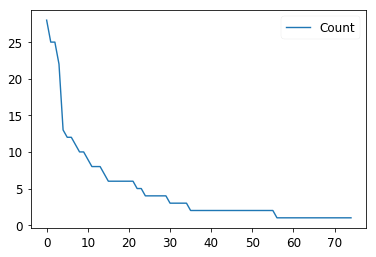

In [13]:
# See the long tail of low frequency doctrines
instance_distributions.plot()

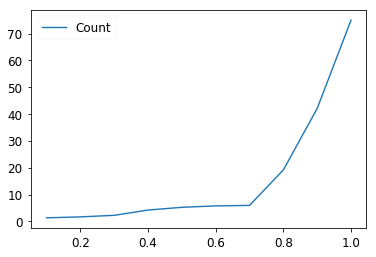

In [14]:
instance_distributions.describe().quantile(np.arange(0.1, 1.1, 0.1)).plot()

### Unique and shared doctrines


In [15]:
def count_unique_doctrines():
    q = ("MATCH (a:Author)--(t:Text)--(:Question)--(i:Instance)--(d:Doctrine) "
         "WITH collect(distinct a) as authors, d "
         "WHERE size(authors) = 1 "
         "UNWIND authors as author "
         "return count(distinct d) as cnt, author.name as name")
    return {d['name']: d['cnt'] for d in graph.run(q).data()}

# Example
unique = count_unique_doctrines()

In [16]:
def count_shared_doctrines(name):
    q = ("MATCH (a:Author)--(:Text)--(:Question)--(i:Instance)--(d:Doctrine) "
         "MATCH (d)--(:Instance)--(:Question)--(:Text)--(a2:Author) "
         "WHERE (a) <> (a2) "
         "return count(distinct d) as cnt, a.name as name")
    return {d['name']: d['cnt'] for d in graph.run(q).data()}

# Example
shared = count_shared_doctrines('John of Jandun')

In [17]:
def unique_to_shared_proportion(name, unique_dict, shared_dict):
    unique = unique_dict.get(name, 0)
    shared = shared_dict.get(name, 0)
    try:
        return unique / (unique + shared)
    except ZeroDivisionError:
        return 0
    
# Example
unique_to_shared_proportion('John of Jandun', unique, shared)

0.42424242424242425

Now let's get the values of these for all the commentators and put them into a matrix.

In [18]:
def unique_shared_doctrines_all(authors, unique_dict, shared_dict):
    d = {}
    for a in authors:
        unique = unique_dict.get(a, 0)
        shared = shared_dict.get(a, 0)
        prop = unique_to_shared_proportion(a, unique_dict, shared_dict)
        
        d[a] = [unique, shared, unique + shared, round(prop, 2)]
    return d

# Example
m = unique_shared_doctrines_all(author_names, unique, shared)

Put this in a DataFrame and sort according to most unique.

In [19]:
df = pd.DataFrame(m, index=['Unique', 'Shared', 'Sum', 'Proportion'])
df = df.T.sort_values(by='Proportion', ascending=False)
df[['Unique', 'Shared', 'Sum']] = df[['Unique', 'Shared', 'Sum']].astype(int)
df

,Unique,Shared,Sum,Proportion
Anonymus Digby 55,7,4,11,0.64
John of Jandun,14,19,33,0.42
Siger of Brabant,2,6,8,0.25
Radulphus Brito,7,22,29,0.24
Anonymus Bazan,3,17,20,0.15
Anonymus Assisi,2,13,15,0.13
John Dinsdale,2,17,19,0.11
Simon of Faversham,1,13,14,0.07
Henric de la Wyle,1,15,16,0.06
Anonymus Vat. Lat. 2170 2,0,12,12,0.00


In [20]:
save_table(
    table=df.to_latex(),
    filename='../thesis/data/tables/process-unique-shared-doctrines.tex',
    label='tab:process:unique-shared-doctrines',
    caption='Unique, shared, total and proportion of unique and shared doctrines.'
)

Printed the following table to ../thesis/data/tables/process-unique-shared-doctrines.tex:
\\begin{table}
\centering
\begin{tabular}{lrrrr}
\toprule
{} &  Unique &  Shared &  Sum &  Proportion \\
\midrule
Anonymus Digby 55         &       7 &       4 &   11 &        0.64 \\
John of Jandun            &      14 &      19 &   33 &        0.42 \\
Siger of Brabant          &       2 &       6 &    8 &        0.25 \\
Radulphus Brito           &       7 &      22 &   29 &        0.24 \\
Anonymus Bazan            &       3 &      17 &   20 &        0.15 \\
Anonymus Assisi           &       2 &      13 &   15 &        0.13 \\
John Dinsdale             &       2 &      17 &   19 &        0.11 \\
Simon of Faversham        &       1 &      13 &   14 &        0.07 \\
Henric de la Wyle         &       1 &      15 &   16 &        0.06 \\
Anonymus Vat. Lat. 2170 2 &       0 &      12 &   12 &        0.00 \\
\bottomrule
\end{tabular}
\caption{Unique, shared, total and proportion of unique and shared doc

In [21]:
# The sums?
df[['Unique', 'Shared', 'Sum']].sum()

Unique     39
Shared    138
Sum       177
dtype: int64

Notice that these numbers are not identical to the sums above. A unique doctrine is a doctrine that has at least one instantiation by exactly one author (i.e. he may use it more than once), while a shared doctrine has at least one instantiation two or more authors. 

This means that the number is a combination of doctrines and instantiations, and is therefore not identical to the separate doctrine and instance sums above. Any correspondence between the two is coincidental.

In [22]:
# Statistical summary
df.describe()

,Unique,Shared,Sum,Proportion
count,10.000000,10.000000,10.00000,10.000000
mean,3.900000,13.800000,17.70000,0.207000
std,4.280446,5.553777,7.91693,0.193681
min,0.000000,4.000000,8.00000,0.000000
25%,1.250000,12.250000,12.50000,0.080000
50%,2.000000,14.000000,15.50000,0.140000
75%,6.000000,17.000000,19.75000,0.247500
max,14.000000,22.000000,33.00000,0.640000


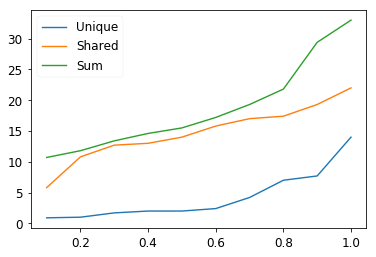

In [23]:
# Plot of the decentiles of unique, shared and sums
df[['Unique', 'Shared', 'Sum']].quantile(np.arange(0.1, 1.1, 0.1)).plot()

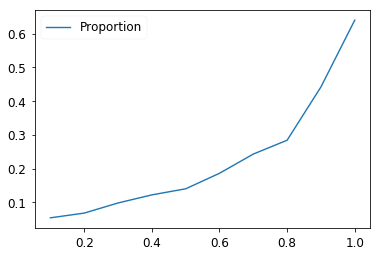

In [24]:
# Plot of the decentiles of the unique-shared proportions
df[['Proportion']].quantile(np.arange(0.1, 1.1, 0.1)).plot()

### Most popular determination and rationes doctrines

#### Rationes doctrines

In [25]:
q = ("match (d:Doctrine)-[:OF]-(i:Instance {type:'Conclusion'})--(:Question)--(:Text)--(a:Author)"
     "return distinct d.description as conclusions, d.label as label, collect(distinct a.name) as names, count(distinct i) as uses "
     "order by uses desc")
graph.run(q).to_table()

conclusions,label,names,uses
Self-knowledge through external species,['D1'],"['Anonymus Vat. Lat. 2170 2', 'Anonymus Assisi', 'John Dinsdale', 'Henric de la Wyle', 'John of Jandun', 'Simon of Faversham']",6
The intellect is self-intelligible,['D7'],"['Anonymus Bazan', 'Anonymus Digby 55', 'John of Jandun']",4
The intellect is intelligible,['D11'],"['Anonymus Bazan', 'Anonymus Assisi', 'Radulphus Brito']",3
Agent intellect known through its products,['D5'],"['Anonymus Bazan', 'Radulphus Brito']",2
Internal experience of own mental faculties,['D17'],['Radulphus Brito'],1
The agent intellect can be understood by the possible intellect,['D24'],['Anonymus Bazan'],1
The intellect can observe its own activity,['D14'],['Radulphus Brito'],1


#### Attacking doctrines

In [26]:
q = ("match (d:Doctrine)<-[:OF]-(i:Instance {type:'Attack'})<-[:HAS]-(q:Question)--(:Text)--(a:Author)"
     "return distinct d.description as Description, d.label as Labels, count(distinct i) as Uses, count(distinct a) as User_count, collect(distinct a.name) as Users "
     "order by length(Users) desc")
popular_attacking = graph.run(q).to_data_frame()
popular_attacking


,Description,Labels,User_count,Users,Uses
0,Intellect not available to sense perception,[N1],5,"[Anonymus Bazan, Henric de la Wyle, John of Ja...",11
1,Identity of knower and known in immaterial sub...,[N2],5,"[Anonymus Vat. Lat. 2170 2, Anonymus Assisi, J...",5
2,Essential self-knowledge in separate intellige...,[N3],5,"[Anonymus Vat. Lat. 2170 2, Anonymus Assisi, J...",5
3,Mover and moved,[N4],4,"[Anonymus Bazan, Anonymus Digby 55, John of Ja...",4
4,Knowing the act of the intellect risks infinit...,[N6],4,"[Anonymus Vat. Lat. 2170 2, John Dinsdale, Joh...",4
5,Analogy with sense and sensation,[N5],3,"[Anonymus Bazan, John of Jandun, Radulphus Brito]",4
6,No abstraction of the intellect,[N7],3,"[Anonymus Bazan, John Dinsdale, Radulphus Brito]",3
7,All intelligibles become intellects if intelle...,[N11],2,"[John Dinsdale, John of Jandun]",2
8,The possible intellect is not actualized,[N23],2,"[Anonymus Bazan, Radulphus Brito]",2
9,Intellect not its own proper object of knowledge,[N8],2,"[Anonymus Bazan, Radulphus Brito]",2


## High level clusters: Proportional distribution matrices

### Determinations

In [27]:
def proportion_shared_determination_doctrines(name):
    q = ("MATCH (a1:Author {name:'%s'})-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(ia:Instance)--(d:Doctrine) "
         "WHERE NOT EXISTS(ia.type) OR ia.type = 'Conclusion' "
         "MATCH (a2:Author)-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(ib:Instance)--(d) "
         "WHERE NOT EXISTS(ib.type) OR ib.type = 'Conclusion' " 
         "MATCH (a1)-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(i1:Instance)--(d1:Doctrine) "
         "WHERE NOT EXISTS(i1.type) OR i1.type = 'Conclusion' "
         "MATCH (a2)-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(i2:Instance)--(d2:Doctrine) "
         "WHERE NOT EXISTS(i2.type) OR i2.type = 'Conclusion' "
         "WITH a2.name as name, count(distinct d) as shared, count(distinct d1) as sum1, count(distinct d2) as sum2 "
         "RETURN name, toFloat(shared) / (sum1 + sum2 - shared) as proportion" % name)
    return {d['name']: d['proportion'] for d in graph.run(q).data()}

proportion_shared_determination_doctrines('John Dinsdale')

{'Anonymus Assisi': 0.46153846153846156,
 'Anonymus Bazan': 0.0625,
 'Anonymus Vat. Lat. 2170 2': 0.7777777777777778,
 'Henric de la Wyle': 0.7777777777777778,
 'John Dinsdale': 1.0,
 'John of Jandun': 0.2,
 'Radulphus Brito': 0.2631578947368421,
 'Siger of Brabant': 0.07142857142857142,
 'Simon of Faversham': 0.6363636363636364}

In [28]:
d = build_matrix(author_names, docfunc=proportion_shared_determination_doctrines)        

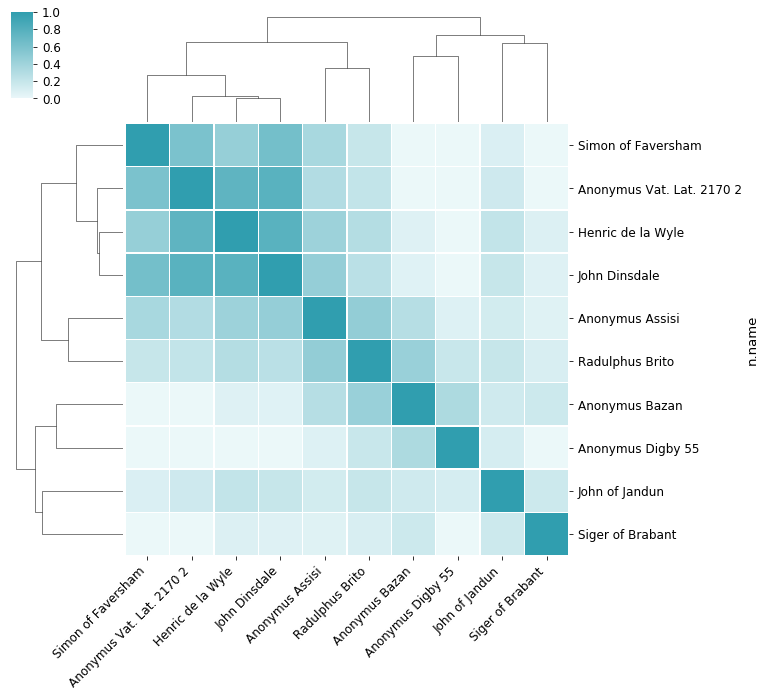

In [29]:
doctrine_frame = pd.DataFrame(d, index=author_names)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), as_cmap=True, input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(doctrine_frame, cmap=cmap, linewidths=.5, row_cluster=True)
for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')


In [30]:
plot.savefig('../thesis/data/figures/process-determ-proportional-clustermap.pdf')
print_figure_inclusion(
    '../figures/process-determ-proportional-clustermap',
    caption='Proportional clustermap of determination doctrines.',
    label='fig:process:determ:prop-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/process-determ-proportional-clustermap.pdf}
\caption{Proportional clustermap of determination doctrines.}
\label{fig:process:determ:prop-clustermap}
\end{figure}


### Rationes

In [31]:
def proportion_shared_rationes_doctrines(name):
    q = ("MATCH (a1:Author {name:'%s'})-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(ia:Instance)--(d:Doctrine) "
         "WHERE ia.type = 'Attack' or ia.type = 'Refutation' "
         "MATCH (a2:Author)-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(ib:Instance)--(d) "
         "WHERE ib.type = 'Attack' or ib.type = 'Refutation' " 
         "MATCH (a1)-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(i1:Instance)--(d1:Doctrine) "
         "WHERE i1.type = 'Attack' or i1.type = 'Refutation' "
         "MATCH (a2)-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(i2:Instance)--(d2:Doctrine) "
         "WHERE i2.type = 'Attack' or i2.type = 'Refutation' "
         "WITH a2.name as name, count(distinct d) as shared, count(distinct d1) as sum1, count(distinct d2) as sum2 "
         "RETURN name, toFloat(shared) / (sum1 + sum2 - shared) as proportion" % name)
    return {d['name']: d['proportion'] for d in graph.run(q).data()}

proportion_shared_rationes_doctrines('John of Jandun')

{'Anonymus Bazan': 0.25,
 'Anonymus Digby 55': 0.07692307692307693,
 'Anonymus Vat. Lat. 2170 2': 0.04,
 'Henric de la Wyle': 0.034482758620689655,
 'John Dinsdale': 0.06666666666666667,
 'John of Jandun': 1.0,
 'Radulphus Brito': 0.21875,
 'Siger of Brabant': 0.045454545454545456,
 'Simon of Faversham': 0.038461538461538464}

In [32]:
rationes_matrix = build_matrix(author_names, docfunc=proportion_shared_rationes_doctrines)

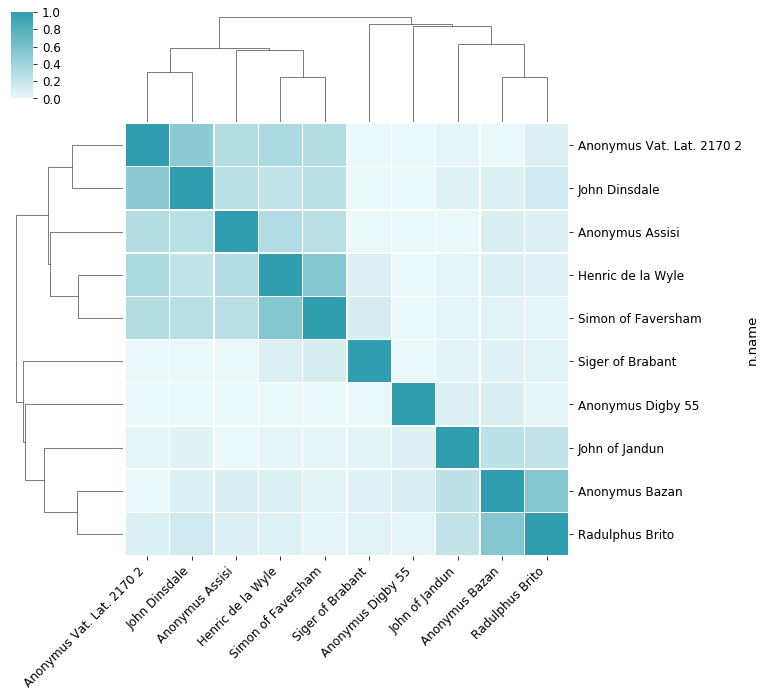

In [33]:
rationes_frame = pd.DataFrame(rationes_matrix, index=author_names)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), as_cmap=True, input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(rationes_frame, cmap=cmap, linewidths=.5, row_cluster=True)
for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')

In [34]:
plot.savefig('../thesis/data/figures/process-rationes-proportional-clustermap.pdf')
print_figure_inclusion(
    '../figures/process-rationes-proportional-clustermap',
    caption='Proportional clustermap of rationes doctrines.',
    label='fig:process:rationes:prop-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/process-rationes-proportional-clustermap.pdf}
\caption{Proportional clustermap of rationes doctrines.}
\label{fig:process:rationes:prop-clustermap}
\end{figure}


### All doctrines

In [35]:
def proportion_shared_doctrines(name):
    shared_data = graph.run(
        "MATCH (a1:Author {name:'%s'})-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(ia:Instance)--(d:Doctrine) "
        "MATCH (a2:Author)-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(ib:Instance)--(d) "
        "RETURN a2.name as name, count(distinct d) as shared" % name
    ).data()
    shared_dict = {d['name']: d['shared'] for d in shared_data}
    proportional_dict = {}
    for other, shared in shared_dict.items():
        sum_start = graph.run(
            "MATCH (:Author {name:'%s'})-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(i1:Instance)--(d1:Doctrine) "
            "RETURN count(distinct d1) " % name
        ).evaluate()
        sum_other = graph.run(
            "MATCH (:Author {name:'%s'})-[:WROTE]->(:Text)-[:CONTAINS]->(:Question)-[:HAS]->(i2:Instance)--(d2:Doctrine) "
            "RETURN count(distinct d2) " % other
        ).evaluate()
        shared_dict[other] = shared / (sum_start + sum_other - shared)
    return shared_dict

dinsdale = proportion_shared_doctrines('John Dinsdale')
dinsdale

{'Anonymus Assisi': 0.36,
 'Anonymus Bazan': 0.11428571428571428,
 'Anonymus Vat. Lat. 2170 2': 0.631578947368421,
 'Henric de la Wyle': 0.4,
 'John Dinsdale': 1.0,
 'John of Jandun': 0.15555555555555556,
 'Radulphus Brito': 0.23076923076923078,
 'Siger of Brabant': 0.08,
 'Simon of Faversham': 0.375}

In [36]:
#Example table of dinsdale
dinsdale_df = pd.DataFrame(dinsdale, index=['Proportion']).round(2)
dinsdale_df.index.name = 'Name'
dinsdale_df = dinsdale_df.T.sort_values(ascending=False, by='Proportion')
dinsdale_df

Name,Proportion
John Dinsdale,1.00
Anonymus Vat. Lat. 2170 2,0.63
Henric de la Wyle,0.40
Simon of Faversham,0.38
Anonymus Assisi,0.36
Radulphus Brito,0.23
John of Jandun,0.16
Anonymus Bazan,0.11
Siger of Brabant,0.08


In [37]:
save_table(
    filename='../thesis/data/tables/dinsdale-fingerprint.tex',
    table=dinsdale_df.to_latex(),
    caption='Relative distribution signature of all doctrines of John Dinsdale.',
    label='tab:process:signature-dinsdale'
)

Printed the following table to ../thesis/data/tables/dinsdale-fingerprint.tex:
\\begin{table}
\centering
\begin{tabular}{lr}
\toprule
Name &  Proportion \\
\midrule
John Dinsdale             &        1.00 \\
Anonymus Vat. Lat. 2170 2 &        0.63 \\
Henric de la Wyle         &        0.40 \\
Simon of Faversham        &        0.38 \\
Anonymus Assisi           &        0.36 \\
Radulphus Brito           &        0.23 \\
John of Jandun            &        0.16 \\
Anonymus Bazan            &        0.11 \\
Siger of Brabant          &        0.08 \\
\bottomrule
\end{tabular}
\caption{Relative distribution signature of all doctrines of John Dinsdale.}
\label{tab:process:signature-dinsdale}
\end{table}


In [38]:
all_matrix = build_matrix(author_names, docfunc=proportion_shared_doctrines)

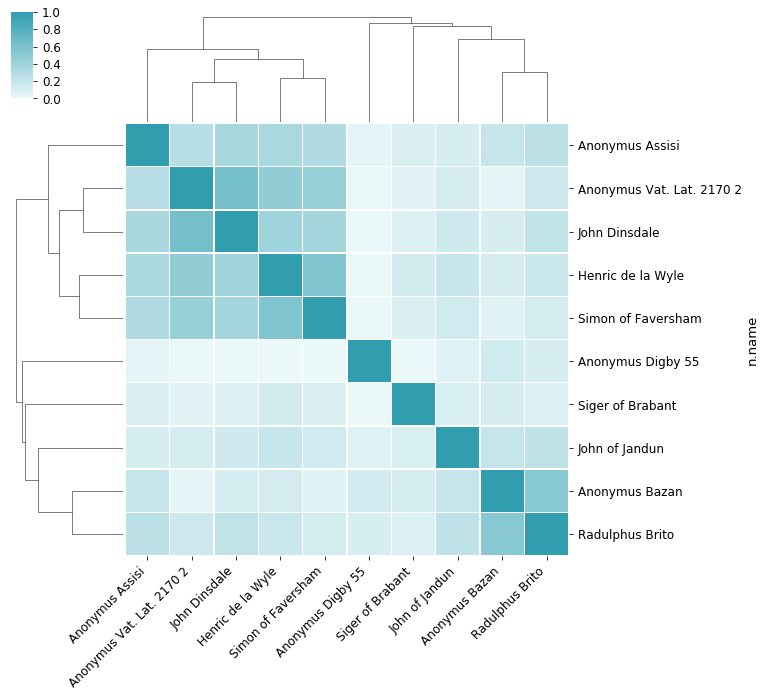

In [39]:
all_frame = pd.DataFrame(all_matrix, index=author_names)

# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), as_cmap=True, input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(all_frame, cmap=cmap, linewidths=.5, row_cluster=True)
for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')

In [40]:
plot.savefig('../thesis/data/figures/process-all-proportional-clustermap.pdf')
print_figure_inclusion(
    '../figures/process-all-proportional-clustermap',
    caption='Proportional clustermap of all doctrines.',
    label='fig:process:all:prop-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/process-all-proportional-clustermap.pdf}
\caption{Proportional clustermap of all doctrines.}
\label{fig:process:all:prop-clustermap}
\end{figure}


Get a path of specific combinations
This matches supporting to a level of 8 nodes.
```
match (:Conclusion)-[:OF]->(dc:Doctrine)
call apoc.path.expand(dc, "<SUPPORTS,<SUPPORTS|<IMPLIES|OF>", "Instance|Doctrine", 1, 8) yield path as pp
return pp
```

# Create doctrinal matrix
Here we want to create a matrix table where it can be seen in more detail which doctrines each commentator uses. It is probably a good idea to distinguish between determination doctrines and rationes doctrines.

First we pull out a list of the names of the doctrines in determinations of each commentator.

## Determination doctrines

In [41]:
def determination_doctrines_of(name):
    q = ("MATCH (a:Author {name:'%s'})--(t:Text)--(q:Question)--(i:Instance)--(d:Doctrine) "
         "WHERE not exists(i.type) or i.type = 'Conclusion' "
         "RETURN distinct d.label as Label, d.description as Doctrine " % name )
    docs = []
    for d in graph.run(q).data():
        if d['Label']:
            docs.append(', '.join(d['Label']) + ': ' + d['Doctrine'])
        else:
            docs.append(d['Doctrine'])
    return docs

# Example test
determination_doctrines_of("John of Jandun")

['D19: Perpetual self-knowledge of agent intellect not available to humans',
 'D18: Possible and agent intellect joined in constant knowledge',
 'D29: Agent intellect the most venerable object of knowledge',
 'D10: Self-knowledge different from the science of the soul',
 'N16: The intellect has essential self-knowledge',
 'Essential self-knowledge results in no self-knowledge',
 'D20: Understanding a blocking activity',
 'D23, N9: Self-knowledge by innate species',
 'D3: Substantial knowledge from accidents',
 'D1: Self-knowledge through external species',
 'D2: Possible intellect completely indeterminate before actualization by external species',
 'D7: The intellect is self-intelligible',
 'D33: Concomitant higher-order understanding',
 'D7: Self-intelligible through external species',
 'D28: The intellect is intelligible like any other thing']

Then we create a full list of all the doctrines in determinations.

In [42]:
def all_determination_doctrines():
    q = ("MATCH (i:Instance)--(d:Doctrine) "
         "WHERE not exists(i.type) or i.type = 'Conclusion' "
         "RETURN distinct d.description as Doctrine, d.label as Label")
    docs = []
    for d in graph.run(q).data():
        if d['Label']:
            docs.append(', '.join(d['Label']) + ': ' + d['Doctrine'])
        else:
            docs.append(d['Doctrine'])
    return docs

all_determination_docs = all_determination_doctrines()

# Test output
all_determination_docs

['D5: Agent intellect known through its products',
 'D11: The intellect is intelligible',
 'D11: Intellect intelligble through external species',
 'D7: The intellect is self-intelligible',
 'D7: Self-intelligible through external species',
 'D9: Successive self-knowledge',
 'D17: Internal experience of own mental faculties',
 'D14: The intellect can observe its own activity',
 'D30: Superiority to sense-perception',
 'D4: An immaterial substance is self-reflexive',
 'D28: The intellect is intelligible like any other thing',
 'D1: Self-knowledge through external species',
 'D2: Possible intellect completely indeterminate before actualization by external species',
 'D16: Analogy with vision: Only things visible in act can be perceived',
 'D13: Intelligibility requires actuality',
 'D3: Substantial knowledge from accidents',
 'D8: Possible intellect similar to prime matter',
 'D6: Great chain of being and the intellect',
 'D20: Understanding a blocking activity',
 'N16: The intellect has 

Now for each author we register how many of the doctrines he ticks off and reads that into a matrix.

In [43]:
matrix = {}
for author in author_names:
    matrix[author] = []
    adocs = determination_doctrines_of(author)
    for doc in all_determination_docs:
        if doc in adocs:
            matrix[author].append(1)
        else:
            matrix[author].append(0)


determination_df = pd.DataFrame(matrix, index=all_determination_docs)
determination_df

,Anonymus Assisi,Anonymus Bazan,Anonymus Digby 55,Anonymus Vat. Lat. 2170 2,Henric de la Wyle,John Dinsdale,John of Jandun,Radulphus Brito,Siger of Brabant,Simon of Faversham
D5: Agent intellect known through its products,0,1,0,0,0,0,0,1,1,0
D11: The intellect is intelligible,1,1,0,0,0,0,0,1,0,0
D11: Intellect intelligble through external species,1,1,0,0,0,0,0,1,0,0
D7: The intellect is self-intelligible,0,1,1,0,0,0,1,1,0,0
D7: Self-intelligible through external species,0,1,1,0,0,0,1,1,0,0
D9: Successive self-knowledge,1,1,1,0,0,0,0,1,0,0
D17: Internal experience of own mental faculties,0,0,0,0,0,0,0,1,0,0
D14: The intellect can observe its own activity,0,0,0,0,0,0,0,1,0,0
D30: Superiority to sense-perception,0,0,0,0,0,0,0,1,0,0
D4: An immaterial substance is self-reflexive,1,0,0,1,1,1,0,1,0,1


In [44]:
sums = determination_df.sum().sort_values(ascending=False)
sums

Radulphus Brito              15
John of Jandun               15
Anonymus Assisi              10
Simon of Faversham            9
John Dinsdale                 9
Anonymus Bazan                8
Henric de la Wyle             7
Anonymus Vat. Lat. 2170 2     7
Siger of Brabant              6
Anonymus Digby 55             4
dtype: int64

What is the mean amount of doctrines?

In [45]:
determination_df.sum().mean()

9.0

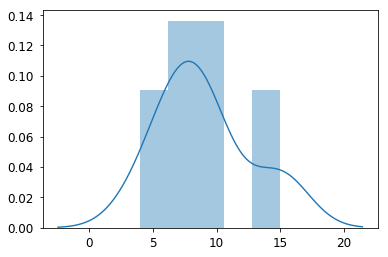

In [46]:
sns.distplot(determination_df.sum())

### Popularity of arguments

In [47]:
determination_df.sum(axis=1).sort_values(ascending=False)

D1: Self-knowledge through external species                                                  7
D2: Possible intellect completely indeterminate before actualization by external species     7
D3: Substantial knowledge from accidents                                                     7
D8: Possible intellect similar to prime matter                                               6
D4: An immaterial substance is self-reflexive                                                6
D6: Great chain of being and the intellect                                                   4
D7: The intellect is self-intelligible                                                       4
D7: Self-intelligible through external species                                               4
D9: Successive self-knowledge                                                                4
D10: Self-knowledge different from the science of the soul                                   4
D11: The intellect is intelligible                

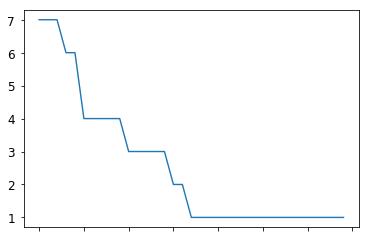

In [48]:
determination_df.sum(axis=1).sort_values(ascending=False).plot()

### Binary matrix cluster analysis
So what if we take the binary matrix representing the presence or absence of a doctrine and use that for clustering?
I have used this as an inspiration: https://stats.stackexchange.com/questions/222492/any-distance-measures-that-are-more-useful-for-binary-data-clustering.
As suggested in the post we use the Hamming metric for distance measuring, as that just counts the number of coordinates that differ. AS it is also mentioned in the scipy documentation it can therefore be used for boolean matrices (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.pdist.html).

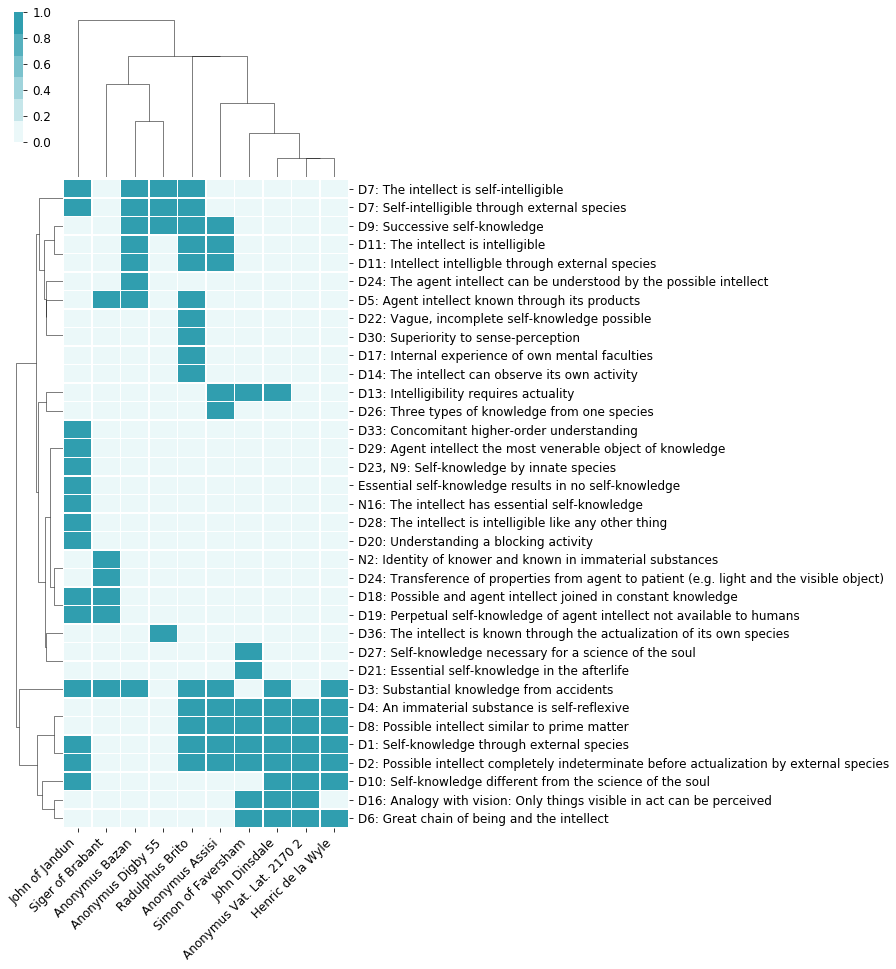

In [49]:
# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(determination_df, cmap=cmap, linewidths=.5, figsize=(6, 15), row_cluster=True, metric='hamming')

for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')

In [50]:
plot.savefig('../thesis/data/figures/process-determination-binary-clustermap.pdf')
print_figure_inclusion(
    'process-determinations-binary-clustermap.pdf',
    caption='Binary doctrinal matrix of determination doctrines.',
    label='fig:process:determination:binary-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/process-determinations-binary-clustermap.pdf}
\caption{Binary doctrinal matrix of determination doctrines.}
\label{fig:process:determination:binary-clustermap}
\end{figure}


## Rationes doctrines

In [51]:
def rationes_doctrines_of(name):
    q = ("MATCH (a:Author {name:'%s'})--(t:Text)--(q:Question)--(i:Instance)--(d:Doctrine) "
         "WHERE i.type = 'Attack' OR i.type = 'Refutation' "
         "RETURN distinct d.label as Label, d.description as Doctrine " % name )
    docs = []
    for d in graph.run(q).data():
        if d['Label']:
            docs.append(', '.join(d['Label']) + ': ' + d['Doctrine'])
        else:
            docs.append(d['Doctrine'])
    return docs

# Example test
rationes_doctrines_of("John of Jandun")

['N1: Intellect not available to sense perception',
 'The intellect can understand completely immaterial things',
 'D4: An immaterial substance is self-reflexive',
 'N5: Analogy with sense and sensation',
 'N11: All intelligibles become intellects if intellect is intelligible',
 'D7: Self-intelligible through external species',
 'D7: The intellect is self-intelligible',
 'N14: Material intelligibles cannot know themselves',
 'N22: Nothing can move itself (knowledge is being-moved)',
 'D31: Primary and secondary intelligibility',
 'N4: Mover and moved',
 'Act and potency with different respects',
 'N12: No simultaneous act and potency',
 'D12: Bodily senses are not reflexive',
 'N15: Diversification of understanding according to object',
 'Diversification only a problem with same mode of being',
 'D32: Multiple simultaneous objects of understanding is possible',
 'N6: Knowing the act of the intellect risks infinite regress',
 'N19: Multiple simultaneous objects of understanding impossib

Then we create a full list of all the doctrines in rationes.

In [52]:
def all_rationes_doctrines():
    q = ("MATCH (i:Instance)--(d:Doctrine) "
         "WHERE i.type = 'Attack' OR i.type = 'Refutation' "
         "RETURN distinct d.label as Label, d.description as Doctrine " )
    docs = []
    for d in graph.run(q).data():
        if d['Label']:
            docs.append(', '.join(d['Label']) + ': ' + d['Doctrine'])
        else:
            docs.append(d['Doctrine'])
    return docs

all_rationes_docs = all_rationes_doctrines()

# Test output
all_rationes_docs

['D14: The intellect can observe its own activity',
 'N5: Analogy with sense and sensation',
 'D12: Bodily senses are not reflexive',
 'N4: Mover and moved',
 'D11: The intellect is intelligible',
 'N8: Intellect not its own proper object of knowledge',
 'D7: The intellect is self-intelligible',
 'D31: Primary and secondary intelligibility',
 'D17: Internal experience of own mental faculties',
 'N23: The possible intellect is not actualized',
 'D11: Intellect intelligble through external species',
 'D34: Only restriction of identity in physical movement',
 'N1: Intellect not available to sense perception',
 'D35: Intellect is perceptible after actualization',
 'N6: Knowing the act of the intellect risks infinite regress',
 'N12: No simultaneous act and potency',
 'Act and potency with different respects',
 'D15: Infinite regress not a problem in the intellect',
 'Only physical movement requires difference between mover and moved',
 'N22: Nothing can move itself (knowledge is being-move

Now for each author we register how many of the doctrines he ticks off and reads that into a matrix.

In [53]:
matrix = {}
for author in author_names:
    matrix[author] = []
    adocs = rationes_doctrines_of(author)
    for doc in all_rationes_docs:
        if doc in adocs:
            matrix[author].append(1)
        else:
            matrix[author].append(0)


rationes_df = pd.DataFrame(matrix, index=all_rationes_docs)
rationes_df

,Anonymus Assisi,Anonymus Bazan,Anonymus Digby 55,Anonymus Vat. Lat. 2170 2,Henric de la Wyle,John Dinsdale,John of Jandun,Radulphus Brito,Siger of Brabant,Simon of Faversham
D14: The intellect can observe its own activity,0,0,0,0,0,0,0,1,0,0
N5: Analogy with sense and sensation,0,1,0,0,0,0,1,1,0,0
D12: Bodily senses are not reflexive,0,1,0,0,0,0,1,1,0,0
N4: Mover and moved,0,1,1,0,0,0,1,1,0,0
D11: The intellect is intelligible,0,1,0,0,0,0,0,1,0,0
N8: Intellect not its own proper object of knowledge,1,1,0,0,0,1,0,1,0,0
D7: The intellect is self-intelligible,0,1,1,0,0,0,1,0,0,0
D31: Primary and secondary intelligibility,0,1,0,0,0,0,1,1,0,0
D17: Internal experience of own mental faculties,0,0,0,0,0,0,0,1,0,0
N23: The possible intellect is not actualized,0,1,0,0,0,0,0,1,0,0


In [54]:
sums = rationes_df.sum().sort_values(ascending=False)
sums

John of Jandun               20
Radulphus Brito              19
Anonymus Bazan               15
John Dinsdale                12
Henric de la Wyle            10
Anonymus Digby 55             8
Simon of Faversham            7
Anonymus Assisi               7
Anonymus Vat. Lat. 2170 2     6
Siger of Brabant              3
dtype: int64

What is the mean amount of doctrines?

In [55]:
rationes_df.sum().mean()

10.7

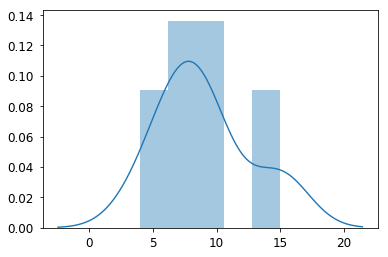

In [56]:
sns.distplot(determination_df.sum())

### Popularity of arguments

In [57]:
rationes_df.sum(axis=1).sort_values(ascending=False)

N1: Intellect not available to sense perception                                             6
D2: Possible intellect completely indeterminate before actualization by external species    5
N2: Identity of knower and known in immaterial substances                                   5
N3: Essential self-knowledge in separate intelligences                                      5
D11: Intellect intelligble through external species                                         4
N4: Mover and moved                                                                         4
N8: Intellect not its own proper object of knowledge                                        4
N6: Knowing the act of the intellect risks infinite regress                                 4
D15: Infinite regress not a problem in the intellect                                        3
N7: No abstraction of the intellect                                                         3
D14: No identity of knower and known before actualization of

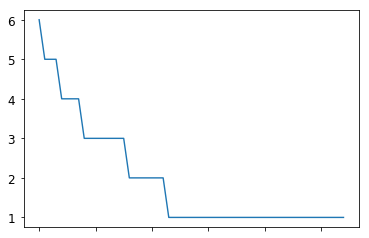

In [58]:
rationes_df.sum(axis=1).sort_values(ascending=False).plot()

### Binary matrix cluster analysis


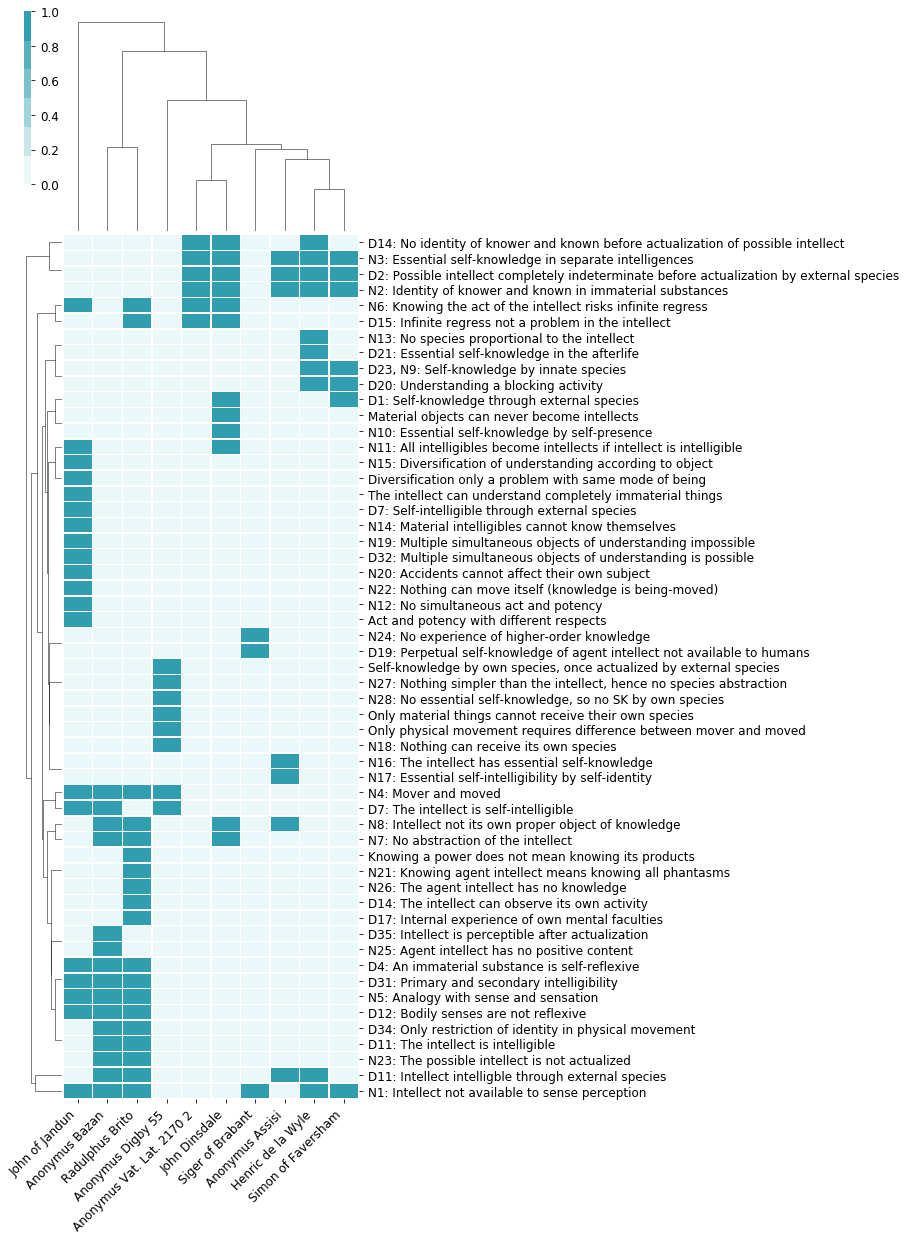

In [59]:
# Generate a custom diverging colormap
cmap = sns.light_palette((210, 90, 60), input="husl")

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.clustermap(rationes_df, cmap=cmap, linewidths=.5, figsize=(6, 20), row_cluster=True, metric='hamming')

for _, ax in enumerate(plot.fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, horizontalalignment='right')

In [60]:
plot.savefig('../thesis/data/figures/process-rationes-binary-clustermap.pdf')
print_figure_inclusion(
    'process-rationes-binary-clustermap.pdf',
    caption='Binary doctrinal matrix of rationes doctrines.',
    label='fig:process:rationes:binary-clustermap')

\begin{figure}
\centering
\includegraphics[width=\linewidth]{data/figures/process-rationes-binary-clustermap.pdf}
\caption{Binary doctrinal matrix of rationes doctrines.}
\label{fig:process:rationes:binary-clustermap}
\end{figure}


# Quantifying centrality

Can we see whether there are some commentators who take up a central position in terms of how big a proportion of doctrines they contain?

Can we also sort them by how by a proportion of the most common doctrines they contain? Will there be any difference between such two measures?

In [61]:
q = ('MATCH (n:Author) RETURN n.name as Name, id(n) as ID ORDER BY n.name asc')
df = graph.run(q).to_data_frame()
author_names = df['Name']
df

,ID,Name
0,4,Anonymus Assisi
1,2,Anonymus Bazan
2,3,Anonymus Digby 55
3,1,Anonymus Vat. Lat. 2170 2
4,6,Henric de la Wyle
5,5,John Dinsdale
6,7,John of Jandun
7,8,Radulphus Brito
8,554,Siger of Brabant
9,10,Simon of Faversham


## Most common doctrines and who has most of them

Who has the highest proportion of the most common doctrines?

First we find the most popular doctrines. Let's take the upper quartile.

In [62]:
# Doctrine count instance distributions
q = ("MATCH (i:Instance)-->(d:Doctrine) "
     "RETURN count(distinct i) as Count, d.description as Description, d.label as Label "
     "ORDER BY Count DESC")

instance_distributions = graph.run(q).to_data_frame()
labels = []
for i in instance_distributions['Label']:
    if i:
        labels.append(', '.join(i))
    else:
        labels.append('')
instance_distributions['Label'] = labels

In [63]:
popular_df = instance_distributions[instance_distributions['Count'] >= int(instance_distributions.quantile(0.67))]
save_table(
    filename='../thesis/data/tables/process-popular-doctrines.tex', 
    table=popular_df.to_latex(index=False),
    caption='Top one third of determination doctrines according to popularity.',
    label='tab:process:most-popular-doctrines')

Printed the following table to ../thesis/data/tables/process-popular-doctrines.tex:
\\begin{table}
\centering
\begin{tabular}{rll}
\toprule
 Count &                                        Description &    Label \\
\midrule
    28 &  Possible intellect completely indeterminate be... &       D2 \\
    25 &            Self-knowledge through external species &       D1 \\
    25 &                 The intellect is self-intelligible &       D7 \\
    22 &        Intellect not available to sense perception &       N1 \\
    13 &          An immaterial substance is self-reflexive &       D4 \\
    12 &              Primary and secondary intelligibility &      D31 \\
    12 &                   Analogy with sense and sensation &       N5 \\
    11 &  Identity of knower and known in immaterial sub... &       N2 \\
    10 &  Essential self-knowledge in separate intellige... &       N3 \\
    10 &                      The intellect is intelligible &      D11 \\
     9 &               Substantial kn

Then, to find out who presents most of these doctrines:
- Read all the doctrines of all the commentators into a dictionary.
- For each commentator, calculate how big a proportion of the most common doctrines he uses.

In [64]:
q = ("MATCH (a:Author)--(:Text)--(:Question)--(:Instance)--(d:Doctrine) "
     "RETURN a.name as Name, collect(distinct d.description) as Doctrines")
commentator_doctrines = {d['Name']: set(d['Doctrines']) for d in graph.run(q).data()}

In [65]:
popular_proportion = {}
popular_set = set(popular_df['Description'])
for name, doctrines in commentator_doctrines.items():
    popular_proportion[name] = len(popular_set & doctrines) / len(popular_set)
popular_proportion

{'Anonymus Assisi': 0.4,
 'Anonymus Bazan': 0.5333333333333333,
 'Anonymus Digby 55': 0.13333333333333333,
 'Anonymus Vat. Lat. 2170 2': 0.3,
 'Henric de la Wyle': 0.43333333333333335,
 'John Dinsdale': 0.43333333333333335,
 'John of Jandun': 0.5666666666666667,
 'Radulphus Brito': 0.7333333333333333,
 'Siger of Brabant': 0.13333333333333333,
 'Simon of Faversham': 0.3333333333333333}

Now let's put the values into a DataFrame for presetational purposes.

In [66]:
popular_prop_df = pd.DataFrame(popular_proportion, index=['Proportion'])
popular_prop_df.index.name = 'Name'
popular_props = popular_prop_df.T.sort_values(ascending=False, by='Proportion').round(2)
save_table(
    filename='../thesis/data/tables/process-popular-proportion.tex', 
    table=popular_props.to_latex(),
    caption='Proportion of most popular doctrines by commentator.',
    label='tab:process:most-popular-proportion')

Printed the following table to ../thesis/data/tables/process-popular-proportion.tex:
\\begin{table}
\centering
\begin{tabular}{lr}
\toprule
Name &  Proportion \\
\midrule
Radulphus Brito           &        0.73 \\
John of Jandun            &        0.57 \\
Anonymus Bazan            &        0.53 \\
Henric de la Wyle         &        0.43 \\
John Dinsdale             &        0.43 \\
Anonymus Assisi           &        0.40 \\
Simon of Faversham        &        0.33 \\
Anonymus Vat. Lat. 2170 2 &        0.30 \\
Anonymus Digby 55         &        0.13 \\
Siger of Brabant          &        0.13 \\
\bottomrule
\end{tabular}
\caption{Proportion of most popular doctrines by commentator.}
\label{tab:process:most-popular-proportion}
\end{table}


In [67]:
commentator_doctrines[popular_props.index[0]] & popular_set

{'Agent intellect known through its products',
 'An immaterial substance is self-reflexive',
 'Analogy with sense and sensation',
 'Bodily senses are not reflexive',
 'Intellect intelligble through external species',
 'Intellect not available to sense perception',
 'Intellect not its own proper object of knowledge',
 'Internal experience of own mental faculties',
 'Knowing the act of the intellect risks infinite regress',
 'Mover and moved',
 'No abstraction of the intellect',
 'Possible intellect completely indeterminate before actualization by external species',
 'Possible intellect similar to prime matter',
 'Primary and secondary intelligibility',
 'Self-intelligible through external species',
 'Self-knowledge through external species',
 'Substantial knowledge from accidents',
 'Successive self-knowledge',
 'The intellect can observe its own activity',
 'The intellect is intelligible',
 'The intellect is self-intelligible',
 'The possible intellect is not actualized'}

In [68]:
commentator_doctrines[popular_props.index[1]] & popular_set

{'All intelligibles become intellects if intellect is intelligible',
 'An immaterial substance is self-reflexive',
 'Analogy with sense and sensation',
 'Bodily senses are not reflexive',
 'Intellect not available to sense perception',
 'Knowing the act of the intellect risks infinite regress',
 'Mover and moved',
 'Possible intellect completely indeterminate before actualization by external species',
 'Primary and secondary intelligibility',
 'Self-intelligible through external species',
 'Self-knowledge by innate species',
 'Self-knowledge different from the science of the soul',
 'Self-knowledge through external species',
 'Substantial knowledge from accidents',
 'The intellect has essential self-knowledge',
 'The intellect is self-intelligible',
 'Understanding a blocking activity'}

In [69]:
commentator_doctrines[popular_props.index[2]] & popular_set

{'Agent intellect known through its products',
 'An immaterial substance is self-reflexive',
 'Analogy with sense and sensation',
 'Bodily senses are not reflexive',
 'Intellect intelligble through external species',
 'Intellect not available to sense perception',
 'Intellect not its own proper object of knowledge',
 'Mover and moved',
 'No abstraction of the intellect',
 'Primary and secondary intelligibility',
 'Self-intelligible through external species',
 'Substantial knowledge from accidents',
 'Successive self-knowledge',
 'The intellect is intelligible',
 'The intellect is self-intelligible',
 'The possible intellect is not actualized'}

## One-sided commonality

Now, let's look at the data in the more one sided perspective of how big a proportion of the material of one commentator is also to be found in the others (regardless of their shared sum of material). So this is the uni-directional, non-symmetric relation. 

This can be described by the metaphor or "outgoing" material, as it lists how much of the doctrines of the starting commentator (`name`) are present in any other commentator.

The hypothesis is that this can be used to investigate which commentators have material that is also present in a high proportion of the other commentators (regardless of how much unique material they might have).

In [70]:
def corpus_count_doctrines():
    """
    Return the number of doctrines in the corpus.
    """
    q = ("MATCH (corpus:Doctrine) RETURN count(distinct corpus) as count ")
    return graph.run(q).evaluate()


corpus_count = corpus_count_doctrines()

In [71]:
distributions = graph.run("match (a:Author)--(:Text)--(:Question)--(:Instance)--(d:Doctrine) "
                              "return count(distinct d) as cnt, a.name order by cnt desc").to_data_frame()
distributions.describe()

,cnt
count,10.00000
mean,17.70000
std,7.91693
min,8.00000
25%,12.50000
50%,15.50000
75%,19.75000
max,33.00000


In [72]:
def outgoing_shared_material(name):
    """
    Return a dictionary of how big a proportion 
    of his doctrines the searched commentator 
    shares with all the others.
    """
    q = ("MATCH (a1:Author {name:'%s'})--(:Text)--(:Question)--(:Instance)--(shared:Doctrine)--(:Instance)--(:Question)--(:Text)--(a2:Author)  "
         "WHERE (a1) <> (a2) "
         "MATCH (a1)--(:Text)--(:Question)--(:Instance)--(own:Doctrine) " 
         "RETURN a2.name as name, count(distinct shared) as shared, count(distinct own) as own " % name)
    return {r['name']:  r['shared'] / r['own'] for r in graph.run(q).data()}

unidir_single = outgoing_shared_material('Anonymus Vat. Lat. 2170 2')
unidir_single

{'Anonymus Assisi': 0.5,
 'Anonymus Bazan': 0.08333333333333333,
 'Henric de la Wyle': 0.75,
 'John Dinsdale': 1.0,
 'John of Jandun': 0.4166666666666667,
 'Radulphus Brito': 0.5,
 'Siger of Brabant': 0.08333333333333333,
 'Simon of Faversham': 0.6666666666666666}

This function normalizes the values against the proportion of doctrines of the author compared to the full corpus. This results in much lower values than the absolute proportions, but corrects for the inaccuracy that rises when the number of doctrines of the author is far from the corpus average.

### Uni-directional overlap in full matrix

This shows how big a proportion of the doctrines of one commentator are also to be found in each of the others. 

This is not a symmetrical relation. 

This will show much much of the material of the column commnentator (X) is present in the others (Y). This only shows how big a proportion of the material (X) is also found in each of the others (Y). It thus does not show how close the two are to each other but merely how close the X is to Y.

Now let's try to build a matrix of those values for all the commentators. By default each column (X) will contain the array of results from the above function. 


In [73]:
uni_rel = build_matrix(author_names, docfunc=outgoing_shared_material)
matrix = pd.DataFrame(uni_rel, index=author_names)
matrix

,Anonymus Assisi,Anonymus Bazan,Anonymus Digby 55,Anonymus Vat. Lat. 2170 2,Henric de la Wyle,John Dinsdale,John of Jandun,Radulphus Brito,Siger of Brabant,Simon of Faversham
Name,,,,,,,,,,
Anonymus Assisi,0.000000,0.30,0.090909,0.500000,0.5000,0.473684,0.151515,0.310345,0.250,0.500000
Anonymus Bazan,0.400000,0.00,0.363636,0.083333,0.2500,0.210526,0.272727,0.586207,0.375,0.142857
Anonymus Digby 55,0.066667,0.20,0.000000,0.000000,0.0000,0.000000,0.090909,0.137931,0.000,0.000000
Anonymus Vat. Lat. 2170 2,0.400000,0.05,0.000000,0.000000,0.5625,0.631579,0.151515,0.206897,0.125,0.571429
Henric de la Wyle,0.533333,0.20,0.000000,0.750000,0.0000,0.526316,0.242424,0.241379,0.375,0.785714
John Dinsdale,0.600000,0.20,0.000000,1.000000,0.6250,0.000000,0.212121,0.310345,0.250,0.642857
John of Jandun,0.333333,0.45,0.272727,0.416667,0.5000,0.368421,0.000000,0.413793,0.500,0.428571
Radulphus Brito,0.600000,0.85,0.363636,0.500000,0.4375,0.473684,0.363636,0.000000,0.375,0.357143
Siger of Brabant,0.133333,0.15,0.000000,0.083333,0.1875,0.105263,0.121212,0.103448,0.000,0.142857


As we use both the values of the columns and rows, we just copy those two transformations of the matrix into two variables.

The difference is the following: 
- The `columns` contains what can be thought of (inaccurately) as outgoing proportions. This will show how much of the material of the column commnentator (X) is present in the others (Y).
- The `rows` contains what can be thought of (inaccurately) as ingoing proportions. This will show how much of the material of the column commentator (X) that is identical with the total doctrines of the row commentator (Y).

In [74]:
cols = matrix
rows = matrix.T

#### Single author proportions

Now with this matrix we can get any of the columns to see the data on that commentator.

In [75]:
cols['John of Jandun'].sort_values(ascending=False)

Name
Radulphus Brito              0.363636
Anonymus Bazan               0.272727
Henric de la Wyle            0.242424
John Dinsdale                0.212121
Simon of Faversham           0.181818
Anonymus Vat. Lat. 2170 2    0.151515
Anonymus Assisi              0.151515
Siger of Brabant             0.121212
Anonymus Digby 55            0.090909
John of Jandun               0.000000
Name: John of Jandun, dtype: float64

This for example shows how big a proportion of Jandun's doctrines are also used by e.g. Brito, Bazan and Wyle (39%, 27%, and 23% as of this writing). 

#### Concentration factor

If we calculate the mean of each of those columns we get a single value for how strong a tendency there is for the doctrines of an author to also be present in other authors.

In other words, this is an indication of how big a proportion of the doctrines of each column commentator other commentators use. 

This means that reading the text of a commentator with a high concetration score, the reader is more likely to read doctrines that are also present in other texts.

In [76]:
concentration = cols.mean().sort_values(ascending=False).round(2)

In [77]:
concentration

Anonymus Vat. Lat. 2170 2    0.40
Henric de la Wyle            0.38
Simon of Faversham           0.36
Anonymus Assisi              0.35
John Dinsdale                0.33
Siger of Brabant             0.25
Anonymus Bazan               0.25
Radulphus Brito              0.25
John of Jandun               0.18
Anonymus Digby 55            0.11
dtype: float64

In [78]:
save_table(
    filename='../thesis/data/tables/process-mean-concentration.tex', 
    table=concentration.to_frame('Proportion').to_latex(),
    caption='Standardized mean concentration factors.',
    label='tab:process:mean-concentration-factor')

Printed the following table to ../thesis/data/tables/process-mean-concentration.tex:
\\begin{table}
\centering
\begin{tabular}{lr}
\toprule
{} &  Proportion \\
\midrule
Anonymus Vat. Lat. 2170 2 &        0.40 \\
Henric de la Wyle         &        0.38 \\
Simon of Faversham        &        0.36 \\
Anonymus Assisi           &        0.35 \\
John Dinsdale             &        0.33 \\
Siger of Brabant          &        0.25 \\
Anonymus Bazan            &        0.25 \\
Radulphus Brito           &        0.25 \\
John of Jandun            &        0.18 \\
Anonymus Digby 55         &        0.11 \\
\bottomrule
\end{tabular}
\caption{Standardized mean concentration factors.}
\label{tab:process:mean-concentration-factor}
\end{table}


Let's collect the two measurements into one and calculate an average.

In [79]:
exemplary = pd.DataFrame(popular_prop_df.T['Proportion'])
exemplary['Concentration'] = concentration
exemplary.columns = ['Common doctrines', 'Concentration']
exemplary['Average'] = (exemplary['Common doctrines'] + exemplary['Concentration']) / 2
exemplary = exemplary.sort_values(by='Average', ascending=False).round(2)
exemplary

,Common doctrines,Concentration,Average
Radulphus Brito,0.73,0.25,0.49
Henric de la Wyle,0.43,0.38,0.41
Anonymus Bazan,0.53,0.25,0.39
John Dinsdale,0.43,0.33,0.38
Anonymus Assisi,0.40,0.35,0.38
John of Jandun,0.57,0.18,0.37
Anonymus Vat. Lat. 2170 2,0.30,0.40,0.35
Simon of Faversham,0.33,0.36,0.35
Siger of Brabant,0.13,0.25,0.19
Anonymus Digby 55,0.13,0.11,0.12


In [80]:
save_table(
    filename='../thesis/data/tables/central-commentators.tex', 
    table=exemplary.to_latex(),
    caption='Proportions of popular doctrines, concentration indices, and the averages.',
    label='tab:process:central-commentators')

Printed the following table to ../thesis/data/tables/central-commentators.tex:
\\begin{table}
\centering
\begin{tabular}{lrrr}
\toprule
{} &  Common doctrines &  Concentration &  Average \\
\midrule
Radulphus Brito           &              0.73 &           0.25 &     0.49 \\
Henric de la Wyle         &              0.43 &           0.38 &     0.41 \\
Anonymus Bazan            &              0.53 &           0.25 &     0.39 \\
John Dinsdale             &              0.43 &           0.33 &     0.38 \\
Anonymus Assisi           &              0.40 &           0.35 &     0.38 \\
John of Jandun            &              0.57 &           0.18 &     0.37 \\
Anonymus Vat. Lat. 2170 2 &              0.30 &           0.40 &     0.35 \\
Simon of Faversham        &              0.33 &           0.36 &     0.35 \\
Siger of Brabant          &              0.13 &           0.25 &     0.19 \\
Anonymus Digby 55         &              0.13 &           0.11 &     0.12 \\
\bottomrule
\end{tabular}
\capt

### Who have high out-going overlap?

Now we can also take the max value of each of column in the recipiency matrix to reveal whether there are some commentators who have a very high out-going overlap, i.e. what the highest outgoing value this commentator has.

In [81]:
max_values_outgoing = pd.DataFrame(cols.max().sort_values(ascending=False), columns=['Value']).round(2)
col = {name: ', '.join(cols.index[cols[name] == cols[name].max()].tolist()) for name in cols.index}
max_values_outgoing['Commentator(s)'] = pd.Series(col)
max_values_outgoing

,Value,Commentator(s)
Anonymus Vat. Lat. 2170 2,1.00,John Dinsdale
Anonymus Bazan,0.85,Radulphus Brito
Simon of Faversham,0.79,Henric de la Wyle
Henric de la Wyle,0.69,Simon of Faversham
John Dinsdale,0.63,Anonymus Vat. Lat. 2170 2
Anonymus Assisi,0.60,"John Dinsdale, Radulphus Brito"
Radulphus Brito,0.59,Anonymus Bazan
Siger of Brabant,0.50,John of Jandun
John of Jandun,0.36,Radulphus Brito
Anonymus Digby 55,0.36,"Anonymus Bazan, Radulphus Brito"


This may be interesting to give hints about possible inheritance or inspiration.

# Playground and scratchpad

In [82]:
def doctrines_of(name):
    q = ("MATCH (q:Question)--(t:Text)--(a:Author {name:'%s'}) "
         "MATCH (q)-[:HAS]->(i:Instance)-->(d:Doctrine) "
         "return distinct d.description " % name)
    return graph.run(q)
doctrines_of('John of Jandun').to_data_frame()

,d.description
0,Perpetual self-knowledge of agent intellect no...
1,Intellect not available to sense perception
2,The intellect can understand completely immate...
3,Possible and agent intellect joined in constan...
4,Agent intellect the most venerable object of k...
5,An immaterial substance is self-reflexive
6,Analogy with sense and sensation
7,Self-knowledge different from the science of t...
8,The intellect has essential self-knowledge
9,Essential self-knowledge results in no self-kn...


In [83]:
def list_attacks(name):
    q = ("MATCH (q:Question)--(t:Text)--(a:Author {name:'%s'}) "
         "MATCH (attack:Instance {type:'Attack'})-[:OF]-(ad:Doctrine) "
         "WHERE (q)-[:HAS]->(attack) "
         "return distinct q.title as Question, ad.description as Attack "
         "order by Question "% name)
    return graph.run(q)

In [84]:
def list_refutations(name):
    q = ("MATCH (q:Question)--(t:Text)--(a:Author {name:'%s'}) "
         "MATCH (refut:Doctrine)<-[:OF]-(refi:Instance {type:'Refutation'})-[:ATTACKS]->(ad:Doctrine) "
         "WHERE (refi)<-[:HAS]-(q) "
         "return distinct q.title as Question, refut.description as Refutation, ad.description as Attack "
         "order by Question " % name)
    return graph.run(q)

In [85]:
q = ("MATCH (a:Author)--(t:Text)--(q:Question) return count(distinct a), count(distinct t), count(distinct q)")
graph.run(q).to_table()

count(distinct a),count(distinct t),count(distinct q)
10,10,17


In [86]:
# Determination doctrines
q = ("MATCH (i:Instance)-[r]->(d:Doctrine) "
     "RETURN count(distinct i) as Count, d.description, id(d), d.label "
     "ORDER BY Count DESC")
graph.run(q).to_data_frame()

,Count,d.description,d.label,id(d)
0,28,Possible intellect completely indeterminate be...,[D2],298
1,25,Self-knowledge through external species,[D1],362
2,25,The intellect is self-intelligible,[D7],81
3,22,Intellect not available to sense perception,[N1],126
4,13,An immaterial substance is self-reflexive,[D4],93
5,12,Analogy with sense and sensation,[N5],131
6,12,Primary and secondary intelligibility,[D31],114
7,11,Identity of knower and known in immaterial sub...,[N2],260
8,10,Essential self-knowledge in separate intellige...,[N3],494
9,10,The intellect is intelligible,[D11],23


In [87]:
graph.run("MATCH (d:Doctrine) where d.description contains('concomitant') return d").data()

[]

In [88]:
graph.run(
    "MATCH (a:Author)--(:Text)--(q:Question)--(i:Instance)-[:OF]-(d:Doctrine) "
    "WHERE not exists(d.label) "
    "return distinct a.name, d.description, d.label, id(d), i.type order by id(d)"
).to_table()

a.name,d.description,d.label,id(d),i.type
John of Jandun,Act and potency with different respects,null,182,Refutation
Anonymus Digby 55,Only physical movement requires difference between mover and moved,null,221,Refutation
Anonymus Digby 55,Only material things cannot receive their own species,null,245,Refutation
John of Jandun,Essential self-knowledge results in no self-knowledge,null,436,null
John Dinsdale,Material objects can never become intellects,null,446,Refutation
John of Jandun,The intellect can understand completely immaterial things,null,502,Refutation
John of Jandun,Diversification only a problem with same mode of being,null,551,Refutation
Radulphus Brito,Knowing a power does not mean knowing its products,null,564,Refutation
Anonymus Digby 55,"Self-knowledge by own species, once actualized by external species",null,680,Refutation
